In [80]:
import numpy
import warnings
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from preprocess.file_manage import load_csv
from setting.paths import TRAIN_DIR, TEST_DIR
import tensorflow as tf
from imblearn.over_sampling import SMOTE
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

In [81]:
def create_dataset(X, y, n_input=3, batch_size=1):
    '''
    Create a dataset suitable for LSTM.

    Parameters:
        X (DataFrame): The input DataFrame.
        y (DataFrame): The target DataFrame.
        n_input (int): The number of time steps to look back.

    Returns:
        TimeseriesGenerator: A generator for training the model.
    '''
    generator = TimeseriesGenerator(
        X.values, y.values, length=n_input, batch_size=batch_size)
    return generator


def build_lstm_model(input_shape):
    '''
    Build and compile the LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data.

    Returns:
        model: Compiled LSTM model.
    '''
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(128, activation='relu',
              return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))  # 0 ~ 3, low-normal-high-heavy
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [82]:
X_train = load_csv(f"{TRAIN_DIR}/X.csv")
y_train = load_csv(f"{TRAIN_DIR}/y.csv")
X_test = load_csv(f"{TEST_DIR}/X.csv")
y_test = load_csv(f"{TEST_DIR}/y.csv")

n_input = 5
batch_size = 64

X_train_reshaped = pandas.DataFrame(X_train.to_numpy().reshape(X_train.shape[0], -1))

original_size = {0: 686, 1: 2887, 2: 287, 3: 901}
smote = SMOTE(sampling_strategy={0: 1500, 1: 2887, 2: 1000, 3: 2000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)

train_gen = create_dataset(
    X_resampled, y_resampled, n_input=n_input, batch_size=batch_size)
test_gen = create_dataset(
    X_test, y_test, n_input=n_input, batch_size=batch_size)

model = build_lstm_model(input_shape=(n_input, X_train.shape[1]))

checkpoint = ModelCheckpoint(
    'LSTM_best_model.keras', save_best_only=True, monitor='loss', mode='min')
# early_stopping = EarlyStopping(
#     monitor='val_loss', patience=10, restore_best_weights=True)
# No validation split for timeseries

history = model.fit(train_gen, epochs=300, batch_size=batch_size,
                    verbose=0, callbacks=[checkpoint])

loss, acc = model.evaluate(test_gen)
print(f'Test Loss: {loss}, Test Accuracy: {acc}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5695 - loss: 1.2252  
Test Loss: 1.1987836360931396, Test Accuracy: 0.5876896977424622


In [83]:
y_pred = model.predict(test_gen)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_test[n_input:], y_pred_classes))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.20      0.03      0.06       146
           1       0.60      0.96      0.74       720
           2       0.00      0.00      0.00        84
           3       0.19      0.01      0.02       236

    accuracy                           0.59      1186
   macro avg       0.25      0.25      0.21      1186
weighted avg       0.43      0.59      0.46      1186



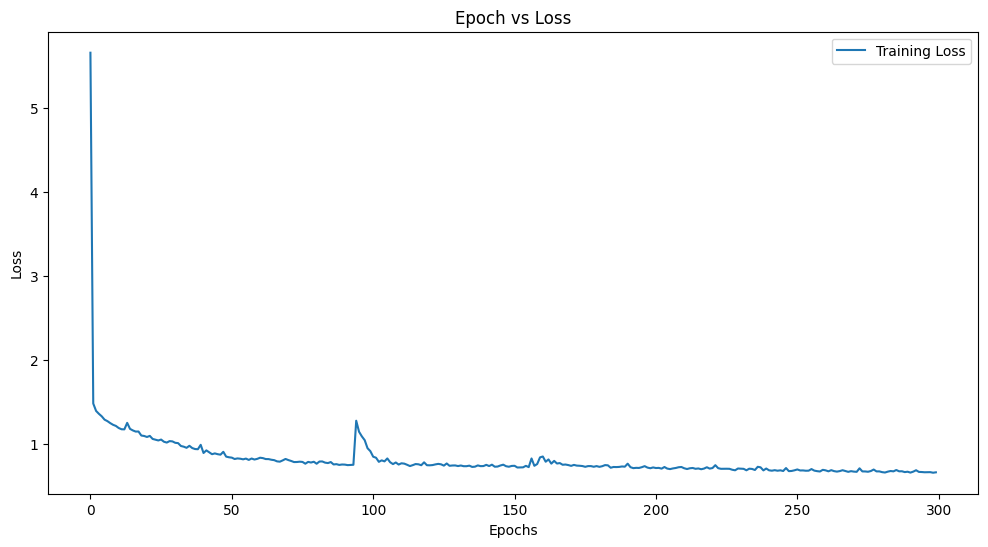

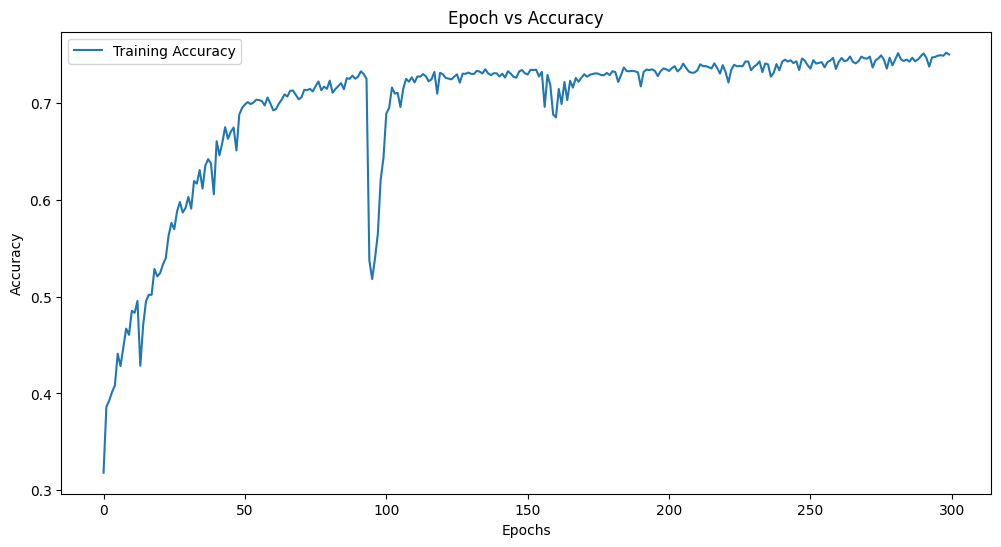

In [84]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()